In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

**1. Preprocessing data**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = '/Users/khoavan/Downloads/tweets.csv'
df = pd.read_csv(file_path)
df.head(5)

,tweet_id,airline,name,text,tweet_coord,tweet_created,tweet_location,user_timezone,sentiment
0,567588000000000000,Delta,JetBlueNews,@JetBlue's new CEO seeks the right balance to ...,NaN,16-02-15 23:36,USA,Sydney,NEUTRAL
1,567590000000000000,Delta,nesi_1992,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,NaN,16-02-15 23:43,undecided,Pacific Time (US & Canada),NEGATIVE
2,567591000000000000,United,CPoutloud,@united yes. We waited in line for almost an h...,NaN,16-02-15 23:48,"Washington, DC",NaN,NEUTRAL
3,567592000000000000,United,brenduch,@united the we got into the gate at IAH on tim...,NaN,16-02-15 23:52,NaN,Buenos Aires,NEUTRAL
4,567594000000000000,Southwest,VahidESQ,@SouthwestAir its cool that my bags take a bit...,NaN,17-02-15 0:00,"Los Angeles, CA",Pacific Time (US & Canada),POSITIVE


First, let's see how large is the dataset, and how many columns are there, and  how many unique values each column has?

In [5]:
print(df.columns)
df.shape

Index(['tweet_id', 'airline', 'name', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone', 'sentiment'],
      dtype='object')


(14640, 9)

Currently, we only care about relevant columns. tweet_id, name are not of our concern. tweet_coord and tweet_created might be useful in some way, but we are not focusing on them right now. Furthermore, we need to remove NaN, but only from essential columns like text, sentiment, and airline. Other columns, though important, can be tolerated if they're NaN. This method of preprocessing has the advantage of not filtering too much data, leaving us plenty to work with.

In [6]:
#Remove irrelevant columns
df = df.drop(columns=['tweet_id', 'name', 'tweet_coord', 'tweet_created'])
df.reset_index(drop=True, inplace=True)
            

In [7]:
#Drop NaN only in essential columns 
df = df.dropna(subset=['text', 'sentiment', 'airline'])
df

,airline,text,tweet_location,user_timezone,sentiment
0,Delta,@JetBlue's new CEO seeks the right balance to ...,USA,Sydney,NEUTRAL
1,Delta,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,undecided,Pacific Time (US & Canada),NEGATIVE
2,United,@united yes. We waited in line for almost an h...,"Washington, DC",NaN,NEUTRAL
3,United,@united the we got into the gate at IAH on tim...,NaN,Buenos Aires,NEUTRAL
4,Southwest,@SouthwestAir its cool that my bags take a bit...,"Los Angeles, CA",Pacific Time (US & Canada),POSITIVE
...,...,...,...,...,...
14635,Delta,@JetBlue I hope so because I fly very often an...,Georgia,Quito,NEGATIVE
14636,US Airways,@USAirways is a DM possible if you aren't foll...,Missourah,Hawaii,NEUTRAL
14637,Delta,@JetBlue Yesterday on my way from EWR to FLL j...,"east brunswick, nj",Atlantic Time (Canada),NEUTRAL
14638,US Airways,@USAirways and when will one of these agents b...,NaN,Atlantic Time (Canada),NEUTRAL


In [8]:
len(df)

14640

Outside of the text column, there are 4 categorical columns: airline, tweet_location, user_timezone, and sentiment. Let's see how many unique values each column has.

In [9]:
categorical = ['airline', 'tweet_location', 'user_timezone', 'sentiment']
for column in categorical:
    print(df[column].unique(), ':', (df[column].nunique()), 'values.')

['Delta' 'United' 'Southwest' 'US Airways' 'Virgin America' 'American'] : 6 values.
['USA' 'undecided' 'Washington, DC' ... "Today I'm in: Maryland"
 'Missourah' 'east brunswick, nj'] : 2989 values.
['Sydney' 'Pacific Time (US & Canada)' nan 'Buenos Aires'
 'Eastern Time (US & Canada)' 'Central Time (US & Canada)'
 'Atlantic Time (Canada)' 'London' 'Tehran' 'Arizona' 'Quito' 'Casablanca'
 'Mountain Time (US & Canada)' 'Dublin' 'Indiana (East)' 'Mazatlan'
 'Hawaii' 'Tijuana' 'America/Chicago' 'Melbourne' 'Greenland' 'Paris'
 'Alaska' 'Rome' 'Amsterdam' 'Seoul' 'Abu Dhabi' 'Caracas' 'Mid-Atlantic'
 'America/New_York' 'Central America' 'Guadalajara' 'Hong Kong'
 'Islamabad' 'Brisbane' 'New Delhi' 'Copenhagen' 'Adelaide' 'Lima'
 'Brasilia' 'Athens' 'Lisbon' 'Berlin' 'Santiago' 'EST' 'Warsaw' 'Bangkok'
 'Singapore' 'Wellington' 'Sarajevo' 'Madrid' 'America/Atikokan' 'Bogota'
 'Beijing' 'New Caledonia' 'Jerusalem' 'Prague' 'Edinburgh' 'Nairobi'
 'Solomon Is.' 'Brussels' 'Istanbul' 'Midway Is

Now let's clean the tweets. The clean_text(text) function converts text to lower case, removes URL, mentions, hashtag, and non-alphabetic characters.

In [10]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)              # Remove URLs
    text = re.sub(r'@\w+', '', text)                 # Remove mentions
    text = re.sub(r"#", '', text)                    # Remove hashtag symbol
    text = re.sub(r'[^a-z\s]', '', text)             # Remove non-alphabetic characters
    return text


In [11]:
df['cleaned text'] = df['text'].map(lambda x: clean_text(x)) 

In [12]:
df

,airline,text,tweet_location,user_timezone,sentiment,cleaned text
0,Delta,@JetBlue's new CEO seeks the right balance to ...,USA,Sydney,NEUTRAL,s new ceo seeks the right balance to please pa...
1,Delta,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,undecided,Pacific Time (US & Canada),NEGATIVE,is really getting on my nerves nothappy
2,United,@united yes. We waited in line for almost an h...,"Washington, DC",NaN,NEUTRAL,yes we waited in line for almost an hour to d...
3,United,@united the we got into the gate at IAH on tim...,NaN,Buenos Aires,NEUTRAL,the we got into the gate at iah on time and h...
4,Southwest,@SouthwestAir its cool that my bags take a bit...,"Los Angeles, CA",Pacific Time (US & Canada),POSITIVE,its cool that my bags take a bit longer dont ...
...,...,...,...,...,...,...
14635,Delta,@JetBlue I hope so because I fly very often an...,Georgia,Quito,NEGATIVE,i hope so because i fly very often and would ...
14636,US Airways,@USAirways is a DM possible if you aren't foll...,Missourah,Hawaii,NEUTRAL,is a dm possible if you arent following me
14637,Delta,@JetBlue Yesterday on my way from EWR to FLL j...,"east brunswick, nj",Atlantic Time (Canada),NEUTRAL,yesterday on my way from ewr to fll just afte...
14638,US Airways,@USAirways and when will one of these agents b...,NaN,Atlantic Time (Canada),NEUTRAL,and when will one of these agents be availabl...


The next step in the preprocessing stage is lemmatization. The preprocess(text) function tokenizes text into words, then lemmatizes them. Lemmatization means reducing words to their stems, or basic forms. 

In [13]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)


In [14]:
df['preprocessed text'] = df['cleaned text'].apply(preprocess)
df['length'] = df['text'].apply(len)      #add feature length, in characters
df['word count'] = df['text'].apply(lambda x: len(x.split()))       #add feature word count

In [15]:
df

,airline,text,tweet_location,user_timezone,sentiment,cleaned text,preprocessed text,length,word count
0,Delta,@JetBlue's new CEO seeks the right balance to ...,USA,Sydney,NEUTRAL,s new ceo seeks the right balance to please pa...,new ceo seek right balance please passenger wa...,127,18
1,Delta,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,undecided,Pacific Time (US & Canada),NEGATIVE,is really getting on my nerves nothappy,really getting nerve nothappy,55,10
2,United,@united yes. We waited in line for almost an h...,"Washington, DC",NaN,NEUTRAL,yes we waited in line for almost an hour to d...,yes waited line almost hour passenger left wan...,115,23
3,United,@united the we got into the gate at IAH on tim...,NaN,Buenos Aires,NEUTRAL,the we got into the gate at iah on time and h...,got gate iah time given seat closed flight kno...,140,29
4,Southwest,@SouthwestAir its cool that my bags take a bit...,"Los Angeles, CA",Pacific Time (US & Canada),POSITIVE,its cool that my bags take a bit longer dont ...,cool bag take bit longer dont give baggage blu...,139,25
...,...,...,...,...,...,...,...,...,...
14635,Delta,@JetBlue I hope so because I fly very often an...,Georgia,Quito,NEGATIVE,i hope so because i fly very often and would ...,hope fly often would hate change airline,78,15
14636,US Airways,@USAirways is a DM possible if you aren't foll...,Missourah,Hawaii,NEUTRAL,is a dm possible if you arent following me,dm possible arent following,55,10
14637,Delta,@JetBlue Yesterday on my way from EWR to FLL j...,"east brunswick, nj",Atlantic Time (Canada),NEUTRAL,yesterday on my way from ewr to fll just afte...,yesterday way ewr fll takeoff wheelsup jetblue...,115,16
14638,US Airways,@USAirways and when will one of these agents b...,NaN,Atlantic Time (Canada),NEUTRAL,and when will one of these agents be availabl...,one agent available speak,67,12


**2. Exploratory data analysis**

Let's see the distribution of sentiments.

<Axes: xlabel='sentiment'>

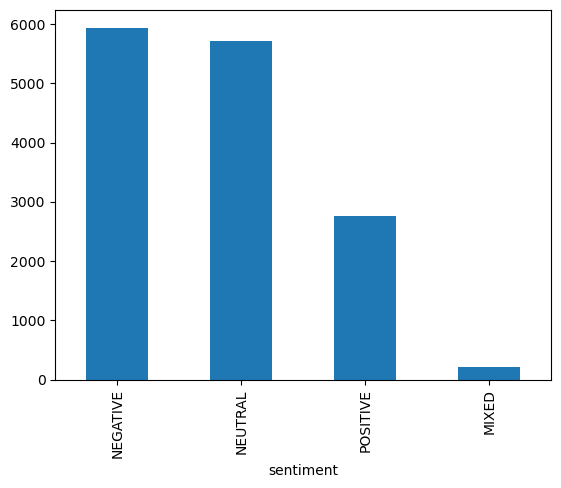

In [16]:
df['sentiment'].value_counts().plot(kind='bar')

Let's see the distribution of word count across sentiments. 

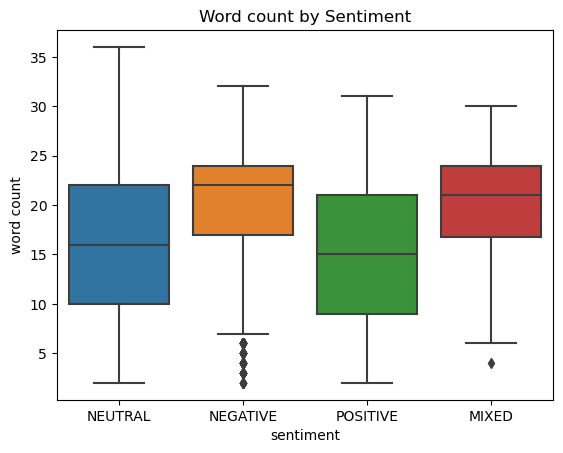

In [17]:
import seaborn as sns
sns.boxplot(data=df, x='sentiment', y='word count')
plt.title("Word count by Sentiment")
plt.show()

Let's find out what are the most frequent words that appear in each sentiment.

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

def top_words_by_sentiment(sentiment_label, n=10):
    texts = df[df['sentiment'] == sentiment_label]['cleaned text']
    vec = CountVectorizer(stop_words='english', max_features=1000)
    X = vec.fit_transform(texts)
    word_freq = zip(vec.get_feature_names_out(), X.sum(axis=0).tolist()[0])
    return sorted(word_freq, key=lambda x: -x[1])[:n]

In [19]:
top_words_by_sentiment("POSITIVE", n=10)

[('thanks', 723),
 ('thank', 527),
 ('flight', 502),
 ('great', 267),
 ('service', 191),
 ('just', 190),
 ('love', 176),
 ('good', 146),
 ('customer', 134),
 ('best', 129)]

In [20]:
top_words_by_sentiment("NEGATIVE", n=10)

[('flight', 1963),
 ('cancelled', 698),
 ('service', 603),
 ('customer', 490),
 ('hours', 453),
 ('just', 404),
 ('hold', 381),
 ('help', 379),
 ('time', 376),
 ('amp', 367)]

In [21]:
top_words_by_sentiment("NEUTRAL", n=10)

[('flight', 1402),
 ('help', 352),
 ('just', 341),
 ('need', 305),
 ('cancelled', 297),
 ('im', 281),
 ('flights', 268),
 ('time', 264),
 ('hold', 228),
 ('plane', 215)]

In [22]:
top_words_by_sentiment("MIXED", n=10)

[('thanks', 36),
 ('just', 31),
 ('flight', 28),
 ('service', 23),
 ('customer', 22),
 ('great', 21),
 ('thank', 17),
 ('appreciate', 14),
 ('like', 14),
 ('love', 14)]

Let's find a way to visualize these statistics better, by using bar charts.

In [23]:
def plot_top_words_all_sentiments(sentiments: list, n=10):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()

    for i, sentiment in enumerate(sentiments):
        top_words = top_words_by_sentiment(sentiment, n)
        if not top_words:
            continue

        words, freqs = zip(*top_words)

        sns.barplot(
            x=list(freqs),
            y=list(words),
            ax=axes[i],
            palette='viridis'
        )
        axes[i].set_title(f"Top {n} Words in {sentiment} Tweets")
        axes[i].set_xlabel("Frequency")
        axes[i].set_ylabel("")

    plt.tight_layout()
    plt.show()

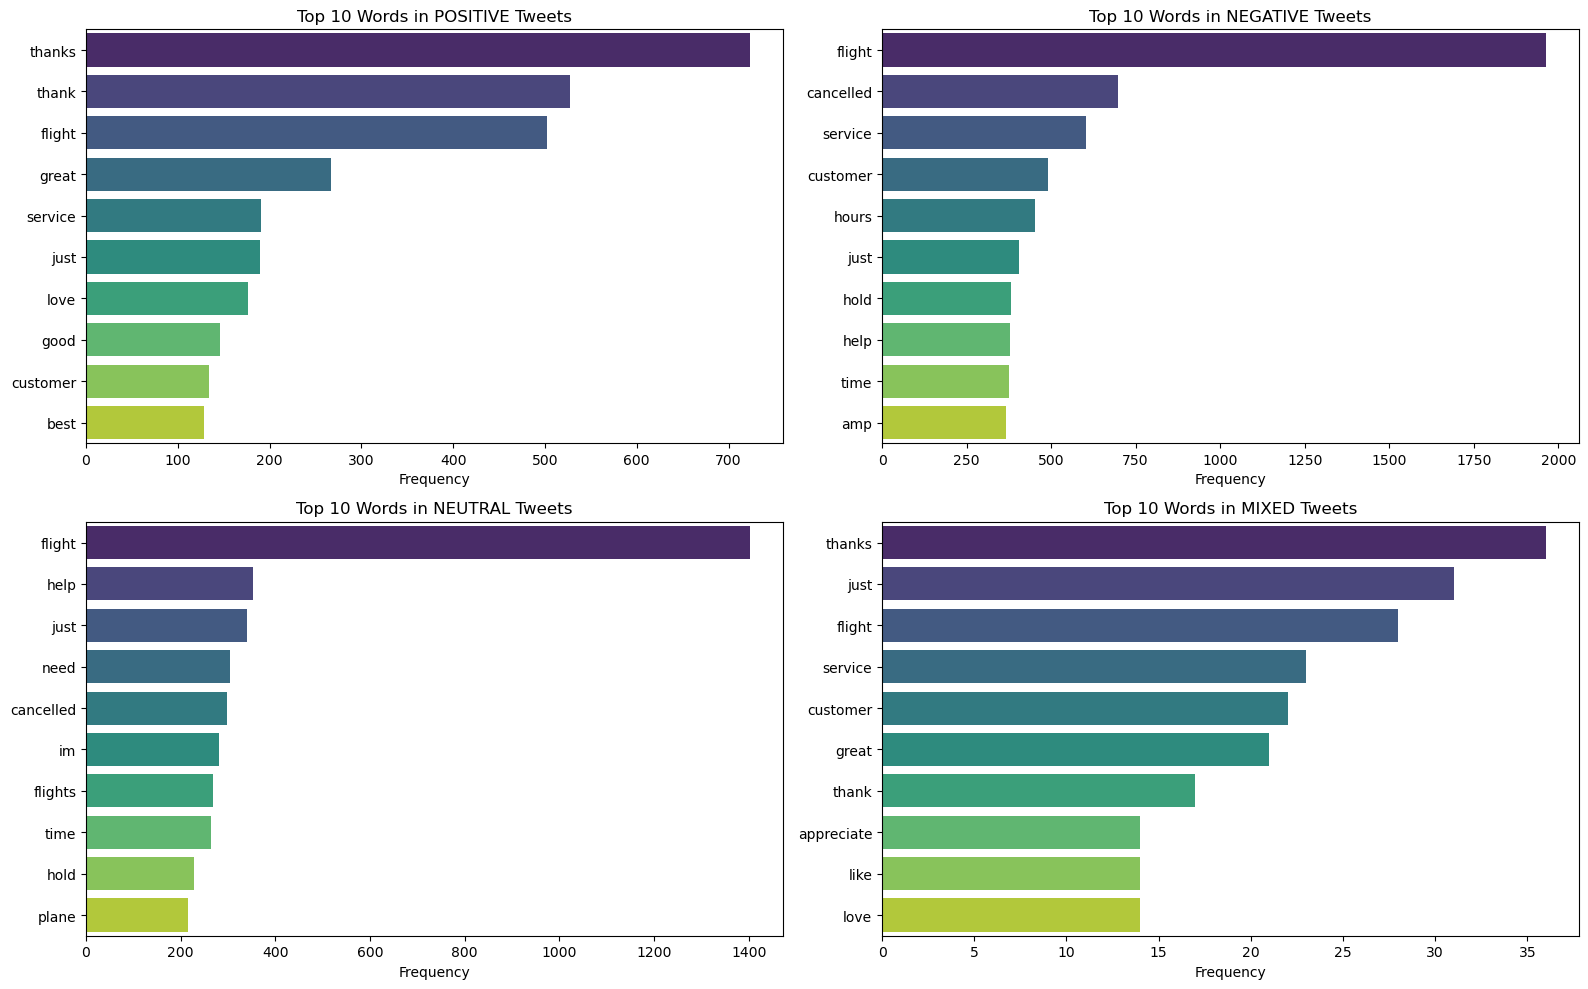

In [24]:
plot_top_words_all_sentiments(sentiments=['POSITIVE', 'NEGATIVE', 'NEUTRAL', 'MIXED'])

**3. Sentiment analysis**

I shall try 2 methods for sentiment analysis. The first method is a rule-based technique called VADER.

In [25]:
"""
VADER (Valence Aware Dictionary and sEntiment Reasoner) method works by analyzing 
the polarity of words and assigning a sentiment score to each word based on its emotional value. 
These individual word scores are then combined to calculate an overall sentiment score for the 
entire text. It uses compound score which is a normalized value between -1 and +1 
representing the overall sentiment:
1. Compound score > 0.05: Positive sentiment
2. Compound score < -0.05: Negative sentiment
3. Compound score between -0.05 and 0.05: Neutral sentiment
"""
#An example of VADER use
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
score = sid.polarity_scores("This airline is awful. Delayed again.")
print(score)
if score['compound'] > 0.05:
    print('POSITIVE')
elif score['compound'] < -0.05:
    print('NEGATIVE')
else:
    print('NEUTRAL')


{'neg': 0.551, 'neu': 0.449, 'pos': 0.0, 'compound': -0.5994}
NEGATIVE


Let's create a labeling function using the VADER method, and store the predictions on the column 'VADER prediction'.

In [26]:
#VADER labeling function
sid = SentimentIntensityAnalyzer()
def VADER_labeler(text: str) -> str:
    score = sid.polarity_scores(text)
    if score['compound'] > 0.05:
        return 'POSITIVE'
    elif score['compound'] < -0.05:
        return 'NEGATIVE'
    else:
        return 'NEUTRAL'


Because the number of mixed data is too small, we can for now omit them, and pretend that there are only 3 sentiment labels.

In [27]:
df_VADER = df[df['sentiment'] != 'MIXED']
df_VADER['VADER prediction'] = df_VADER['preprocessed text'].apply(VADER_labeler)

/var/folders/nt/frbtbjrs5f7g0hhpjym9rrtr0000gn/T/ipykernel_23603/1292291672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_VADER['VADER prediction'] = df_VADER['preprocessed text'].apply(VADER_labeler)


In [28]:
df_VADER

,airline,text,tweet_location,user_timezone,sentiment,cleaned text,preprocessed text,length,word count,VADER prediction
0,Delta,@JetBlue's new CEO seeks the right balance to ...,USA,Sydney,NEUTRAL,s new ceo seeks the right balance to please pa...,new ceo seek right balance please passenger wa...,127,18,POSITIVE
1,Delta,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,undecided,Pacific Time (US & Canada),NEGATIVE,is really getting on my nerves nothappy,really getting nerve nothappy,55,10,NEUTRAL
2,United,@united yes. We waited in line for almost an h...,"Washington, DC",NaN,NEUTRAL,yes we waited in line for almost an hour to d...,yes waited line almost hour passenger left wan...,115,23,POSITIVE
3,United,@united the we got into the gate at IAH on tim...,NaN,Buenos Aires,NEUTRAL,the we got into the gate at iah on time and h...,got gate iah time given seat closed flight kno...,140,29,NEUTRAL
4,Southwest,@SouthwestAir its cool that my bags take a bit...,"Los Angeles, CA",Pacific Time (US & Canada),POSITIVE,its cool that my bags take a bit longer dont ...,cool bag take bit longer dont give baggage blu...,139,25,POSITIVE
...,...,...,...,...,...,...,...,...,...,...
14635,Delta,@JetBlue I hope so because I fly very often an...,Georgia,Quito,NEGATIVE,i hope so because i fly very often and would ...,hope fly often would hate change airline,78,15,NEGATIVE
14636,US Airways,@USAirways is a DM possible if you aren't foll...,Missourah,Hawaii,NEUTRAL,is a dm possible if you arent following me,dm possible arent following,55,10,NEUTRAL
14637,Delta,@JetBlue Yesterday on my way from EWR to FLL j...,"east brunswick, nj",Atlantic Time (Canada),NEUTRAL,yesterday on my way from ewr to fll just afte...,yesterday way ewr fll takeoff wheelsup jetblue...,115,16,NEUTRAL
14638,US Airways,@USAirways and when will one of these agents b...,NaN,Atlantic Time (Canada),NEUTRAL,and when will one of these agents be availabl...,one agent available speak,67,12,NEUTRAL


A skim through our dataframe shows that our method is somewhat off, at least. Let's evaluate its performance. We shall use metrics like accuracy, precision, f1, and recall.

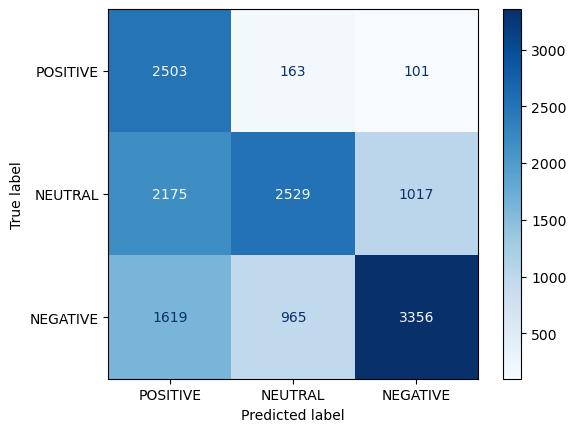

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true=df_VADER['sentiment'], y_pred=df_VADER['VADER prediction'], labels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])
disp.plot(cmap='Blues')


In [30]:
from sklearn.metrics import accuracy_score, classification_report
report = classification_report(df_VADER['sentiment'], df_VADER['VADER prediction'])
accuracy = accuracy_score(df_VADER['sentiment'], df_VADER['VADER prediction'])
print(f'Accuracy: {accuracy}')
print(report)

Accuracy: 0.581369559190463
              precision    recall  f1-score   support

    NEGATIVE       0.75      0.56      0.64      5940
     NEUTRAL       0.69      0.44      0.54      5721
    POSITIVE       0.40      0.90      0.55      2767

    accuracy                           0.58     14428
   macro avg       0.61      0.64      0.58     14428
weighted avg       0.66      0.58      0.59     14428



Based on the confusion matrix and the evaluation metrics, we can see that our performance isn't very good. In order to properly deal with this problem, we need some sort of machine learning.

**4. Machine learning**

The second method utilizes machine learning techniques to achieve better predictions.

In [31]:
data = df['preprocessed text']
labels = df['sentiment']

In [32]:
#Logistic regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.3, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print(f"Train size: {X_train.shape}")
print(f"Validation size: {X_val.shape}")
print(f"Test size: {X_test.shape}")

Train size: (10248,)
Validation size: (2196,)
Test size: (2196,)


In [ ]:
from sklearn.preprocessing import LabelEncoder

#Vectorize data into Tf-idf vectors
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

#Encode sentiment labels with categorical values
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)


In [34]:
encoder.classes_

array(['MIXED', 'NEGATIVE', 'NEUTRAL', 'POSITIVE'], dtype=object)

In [35]:
#Train using logistic regression
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
y_pred_val = lr_clf.predict(X_val)
print(classification_report(y_val, y_pred_val, target_names=list(encoder.classes_)))

              precision    recall  f1-score   support

       MIXED       0.00      0.00      0.00        32
    NEGATIVE       0.72      0.74      0.73       891
     NEUTRAL       0.69      0.74      0.71       858
    POSITIVE       0.82      0.72      0.76       415

    accuracy                           0.72      2196
   macro avg       0.56      0.55      0.55      2196
weighted avg       0.72      0.72      0.72      2196



/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
y_pred = lr_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=list(encoder.classes_)))

              precision    recall  f1-score   support

       MIXED       0.00      0.00      0.00        32
    NEGATIVE       0.71      0.75      0.73       891
     NEUTRAL       0.69      0.73      0.71       858
    POSITIVE       0.85      0.70      0.77       415

    accuracy                           0.72      2196
   macro avg       0.56      0.55      0.55      2196
weighted avg       0.72      0.72      0.72      2196



/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


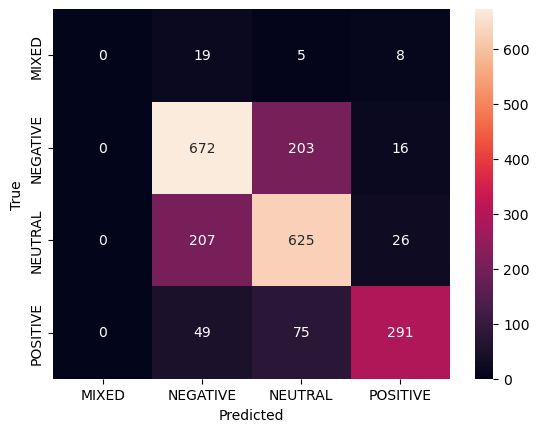

In [37]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=list(encoder.classes_), yticklabels=list(encoder.classes_))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

For negative and neutral labels our logistic regression model has quite good performance, but on the other labels the prediction is very bad, especially for the mixed label.

Let's then try other methods. For instance, random forest.

In [38]:
from sklearn.ensemble import RandomForestClassifier

#Random forest
rf_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_clf.fit(X_train, y_train)

#Predict on validation set
y_pred_val = rf_clf.predict(X_val)
print(classification_report(y_val, y_pred_val, target_names=encoder.classes_))

              precision    recall  f1-score   support

       MIXED       0.00      0.00      0.00        32
    NEGATIVE       0.72      0.67      0.70       891
     NEUTRAL       0.66      0.73      0.69       858
    POSITIVE       0.74      0.75      0.74       415

    accuracy                           0.70      2196
   macro avg       0.53      0.54      0.53      2196
weighted avg       0.69      0.70      0.69      2196



/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The accuracy is 70% which is worse than logistic regression. However, we can try tuning hyperparameters.

In [39]:
%pip install scikit-optimize


Note: you may need to restart the kernel to use updated packages.


In [40]:
from skopt import gp_minimize
from skopt.space import Integer, Categorical
from sklearn.metrics import f1_score

#Bayesian optimization
search_space = [                                    #define search space over parameters
    Integer(50, 300, name='n_estimators'),
    Integer(5, 30, name='max_depth'),
    Integer(2, 20, name='min_samples_split'),
    Integer(1, 10, name='min_samples_leaf'),
    Categorical(['sqrt', 'log2', None], name='max_features'),
]

def objective(params):                              #define the objective function
    n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features = params
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1       #Parallel processing
    )
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    f1 = f1_score(y_val, y_pred_val, average='macro')
    return -f1  # minimize negative F1


In [41]:
#Run search
result = gp_minimize(objective, search_space, n_calls=30, random_state=42)
print("Best hyperparameters:")
print(f"n_estimators: {result.x[0]}")
print(f"max_depth: {result.x[1]}")
print(f"min_samples_split: {result.x[2]}")
print(f"min_samples_leaf: {result.x[3]}")
print(f"max_features: {result.x[4]}")

print(f"Best validation F1 (macro): {-result.fun:.4f}")

Best hyperparameters:
n_estimators: 300
max_depth: 25
min_samples_split: 20
min_samples_leaf: 1
max_features: log2
Best validation F1 (macro): 0.5552


In [42]:
best_n_estimators = result.x[0]
best_max_depth = result.x[1]
best_min_samples_split = result.x[2]
best_min_samples_leaf = result.x[3]
best_max_features = result.x[4]
#Best random forest model
best_rf = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    max_features=best_max_features,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=25,
                       max_features='log2', min_samples_split=20,
                       n_estimators=300, n_jobs=-1, random_state=42)

In [43]:
y_pred_val = best_rf.predict(X_val)
print(classification_report(y_val, y_pred_val, target_names=encoder.classes_))

              precision    recall  f1-score   support

       MIXED       0.11      0.06      0.08        32
    NEGATIVE       0.73      0.68      0.70       891
     NEUTRAL       0.67      0.69      0.68       858
    POSITIVE       0.72      0.80      0.76       415

    accuracy                           0.70      2196
   macro avg       0.56      0.56      0.56      2196
weighted avg       0.70      0.70      0.70      2196



In [44]:
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

              precision    recall  f1-score   support

       MIXED       0.19      0.09      0.12        32
    NEGATIVE       0.72      0.71      0.71       891
     NEUTRAL       0.68      0.70      0.69       858
    POSITIVE       0.75      0.76      0.76       415

    accuracy                           0.71      2196
   macro avg       0.58      0.57      0.57      2196
weighted avg       0.70      0.71      0.70      2196



So we bring the accuracy up by 1%. Meanwhile, the best model also succeeds in predicting mixed label, albeit poorly.
Next, we can try support vector machine.

In [45]:
from sklearn.svm import SVC

#Support vector machine with linear kernel
svm_linear = SVC(kernel='linear', class_weight='balanced', probability=True, random_state=42)
svm_linear.fit(X_train, y_train)
y_pred_val = svm_linear.predict(X_val)
print(classification_report(y_val, y_pred_val, target_names=encoder.classes_))

              precision    recall  f1-score   support

       MIXED       0.13      0.12      0.13        32
    NEGATIVE       0.74      0.69      0.72       891
     NEUTRAL       0.70      0.73      0.71       858
    POSITIVE       0.73      0.77      0.75       415

    accuracy                           0.71      2196
   macro avg       0.58      0.58      0.58      2196
weighted avg       0.71      0.71      0.71      2196



Right from the start, without any optimization we already achieved positive scores for mixed label.

In [46]:
#Support vector machine with RBF kernel
svm_rbf = SVC(kernel='rbf', class_weight='balanced', probability=True, random_state=42)
svm_rbf.fit(X_train, y_train)
y_pred_val = svm_rbf.predict(X_val)
print(classification_report(y_val, y_pred_val, target_names=encoder.classes_))

              precision    recall  f1-score   support

       MIXED       0.00      0.00      0.00        32
    NEGATIVE       0.74      0.69      0.72       891
     NEUTRAL       0.67      0.76      0.72       858
    POSITIVE       0.77      0.74      0.76       415

    accuracy                           0.72      2196
   macro avg       0.55      0.55      0.55      2196
weighted avg       0.71      0.72      0.71      2196



/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The accuracies of both kernels are close, but the RBF kernel fails to score positive metrics on mixed label. We'll perform hyperparameter tuning on the linear kernel.

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

#Tune hyperparameters with grid search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced'],
    'max_iter': [1000, 5000]
}

svm = LinearSVC(random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)
print("Best CV F1 macro score:", grid_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/a

[CV] END ...........C=0.01, class_weight=None, max_iter=1000; total time=   0.0s
[CV] END ...........C=0.01, class_weight=None, max_iter=5000; total time=   0.0s
[CV] END ...........C=0.01, class_weight=None, max_iter=5000; total time=   0.0s
[CV] END .......C=0.01, class_weight=balanced, max_iter=1000; total time=   0.0s
[CV] END ...........C=0.01, class_weight=None, max_iter=1000; total time=   0.0s
[CV] END ...........C=0.01, class_weight=None, max_iter=1000; total time=   0.0s
[CV] END ...........C=0.01, class_weight=None, max_iter=5000; total time=   0.0s
[CV] END .......C=0.01, class_weight=balanced, max_iter=1000; total time=   0.0s
[CV] END .......C=0.01, class_weight=balanced, max_iter=1000; total time=   0.0s
[CV] END .......C=0.01, class_weight=balanced, max_iter=5000; total time=   0.0s
[CV] END .......C=0.01, class_weight=balanced, max_iter=5000; total time=   0.0s
[CV] END .......C=0.01, class_weight=balanced, max_iter=5000; total time=   0.0s
[CV] END ............C=0.1, 

/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/a

[CV] END .............C=10, class_weight=None, max_iter=1000; total time=   0.3s
[CV] END .............C=10, class_weight=None, max_iter=1000; total time=   0.3s
[CV] END .............C=10, class_weight=None, max_iter=5000; total time=   0.2s
[CV] END .............C=10, class_weight=None, max_iter=5000; total time=   0.3s
[CV] END .............C=10, class_weight=None, max_iter=1000; total time=   0.3s
[CV] END .........C=10, class_weight=balanced, max_iter=1000; total time=   0.3s
[CV] END .............C=10, class_weight=None, max_iter=5000; total time=   0.3s
[CV] END .........C=10, class_weight=balanced, max_iter=1000; total time=   0.3s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/a

[CV] END .........C=10, class_weight=balanced, max_iter=5000; total time=   0.2s
[CV] END .........C=10, class_weight=balanced, max_iter=1000; total time=   0.4s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END .........C=10, class_weight=balanced, max_iter=5000; total time=   0.5s
[CV] END .........C=10, class_weight=balanced, max_iter=5000; total time=   0.5s
[CV] END ............C=100, class_weight=None, max_iter=1000; total time=   0.6s
[CV] END ............C=100, class_weight=None, max_iter=1000; total time=   0.6s
[CV] END ............C=100, class_weight=None, max_iter=1000; total time=   0.6s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242

[CV] END ........C=100, class_weight=balanced, max_iter=1000; total time=   0.5s
[CV] END ........C=100, class_weight=balanced, max_iter=1000; total time=   0.6s
[CV] END ........C=100, class_weight=balanced, max_iter=1000; total time=   0.6s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............C=100, class_weight=None, max_iter=5000; total time=   2.0s
[CV] END ............C=100, class_weight=None, max_iter=5000; total time=   2.2s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............C=100, class_weight=None, max_iter=5000; total time=   2.1s
[CV] END ........C=100, class_weight=balanced, max_iter=5000; total time=   1.9s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........C=100, class_weight=balanced, max_iter=5000; total time=   2.2s
[CV] END ........C=100, class_weight=balanced, max_iter=5000; total time=   2.0s
Best hyperparameters: {'C': 1, 'class_weight': 'balanced', 'max_iter': 1000}
Best CV F1 macro score: 0.5434927251983231


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [48]:
best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_val)
print(classification_report(y_val, y_pred_val, target_names=encoder.classes_))

              precision    recall  f1-score   support

       MIXED       0.19      0.16      0.17        32
    NEGATIVE       0.73      0.69      0.71       891
     NEUTRAL       0.69      0.71      0.70       858
    POSITIVE       0.74      0.79      0.76       415

    accuracy                           0.71      2196
   macro avg       0.59      0.59      0.59      2196
weighted avg       0.71      0.71      0.71      2196



In [49]:
from scipy.sparse import vstack

X_train_val = vstack([X_train, X_val])
y_train_val = list(y_train) + list(y_val)
best_model.fit(X_train_val, y_train_val)        #Retrain using best model

/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(C=1, class_weight='balanced', random_state=42)

In [50]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

              precision    recall  f1-score   support

       MIXED       0.09      0.06      0.07        32
    NEGATIVE       0.74      0.74      0.74       891
     NEUTRAL       0.73      0.72      0.72       858
    POSITIVE       0.77      0.81      0.79       415

    accuracy                           0.73      2196
   macro avg       0.58      0.58      0.58      2196
weighted avg       0.73      0.73      0.73      2196



Overall, the metrics on major labels improve, and accuracy is better, but at the expense of the mixed label.

Let's try embedding using sentence_transformer, which might better embed the meanings of words.

In [51]:
from sentence_transformers import SentenceTransformer

class EmbeddingGenerator:
    def __init__(self, model_name: str = 'all-MiniLM-L6-v2'):
        print(f"Loading embedding model: {model_name}")
        self.model = SentenceTransformer(model_name)

    def encode_texts(self, texts, batch_size: int = 32) -> np.ndarray:
        """
        Encode a list of texts into sentence embeddings.

        Parameters:
        - texts: list-like (list of strings or pd.Series)
        - batch_size: batch size for encoding

        Returns:
        - numpy array of shape (n_samples, embedding_dim)
        """
        # Convert pandas Series to list if needed
        if isinstance(texts, pd.Series):
            texts = texts.tolist()
            
        embeddings = self.model.encode(
            texts, 
            show_progress_bar=True, 
            batch_size=batch_size
        )
        return np.array(embeddings)

In [56]:
# Embed
embedder = EmbeddingGenerator()
X = embedder.encode_texts(df['text'], batch_size=8)

# Encode sentiment labels
encoder = LabelEncoder()
y = encoder.fit_transform(df['sentiment'])

# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

Loading embedding model: all-MiniLM-L6-v2


Batches:   0%|          | 0/1830 [00:00<?, ?it/s]

Now we try all these models again.

In [57]:
# Train using logistic regression
lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=list(encoder.classes_)))

              precision    recall  f1-score   support

       MIXED       0.00      0.00      0.00        32
    NEGATIVE       0.77      0.83      0.80       891
     NEUTRAL       0.74      0.77      0.76       858
    POSITIVE       0.86      0.74      0.80       415

    accuracy                           0.78      2196
   macro avg       0.59      0.58      0.59      2196
weighted avg       0.77      0.78      0.77      2196



/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [59]:
#Random forest
rf_clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_clf.fit(X_train, y_train)

#Predict on validation set
y_pred = rf_clf.predict(X_val)
print(classification_report(y_val, y_pred_val, target_names=encoder.classes_))

              precision    recall  f1-score   support

       MIXED       0.19      0.16      0.17        32
    NEGATIVE       0.73      0.69      0.71       891
     NEUTRAL       0.69      0.71      0.70       858
    POSITIVE       0.74      0.79      0.76       415

    accuracy                           0.71      2196
   macro avg       0.59      0.59      0.59      2196
weighted avg       0.71      0.71      0.71      2196



In [60]:
# Bayesian optimization
result = gp_minimize(objective, search_space, n_calls=30, random_state=42)
print("Best hyperparameters:")
print(f"n_estimators: {result.x[0]}")
print(f"max_depth: {result.x[1]}")
print(f"min_samples_split: {result.x[2]}")
print(f"min_samples_leaf: {result.x[3]}")
print(f"max_features: {result.x[4]}")

print(f"Best validation F1 (macro): {-result.fun:.4f}")

Best hyperparameters:
n_estimators: 239
max_depth: 16
min_samples_split: 6
min_samples_leaf: 6
max_features: sqrt
Best validation F1 (macro): 0.5462


In [61]:
# Retrain with best model
best_n_estimators = result.x[0]
best_max_depth = result.x[1]
best_min_samples_split = result.x[2]
best_min_samples_leaf = result.x[3]
best_max_features = result.x[4]
#Best random forest model
best_rf = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    max_features=best_max_features,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=16,
                       min_samples_leaf=6, min_samples_split=6,
                       n_estimators=239, n_jobs=-1, random_state=42)

In [62]:
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=list(encoder.classes_)))

              precision    recall  f1-score   support

       MIXED       0.00      0.00      0.00        32
    NEGATIVE       0.71      0.81      0.76       891
     NEUTRAL       0.70      0.67      0.69       858
    POSITIVE       0.82      0.69      0.75       415

    accuracy                           0.72      2196
   macro avg       0.56      0.54      0.55      2196
weighted avg       0.72      0.72      0.72      2196



/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
# Grid search for Linear SVM
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced'],
    'max_iter': [1000, 5000]
}

svm = LinearSVC(random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=3, scoring='f1_macro', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)
print("Best CV F1 macro score:", grid_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/a

[CV] END ...........C=0.01, class_weight=None, max_iter=1000; total time=   0.7s
[CV] END ...........C=0.01, class_weight=None, max_iter=5000; total time=   0.7s
[CV] END ...........C=0.01, class_weight=None, max_iter=1000; total time=   0.7s
[CV] END .......C=0.01, class_weight=balanced, max_iter=1000; total time=   0.7s
[CV] END ...........C=0.01, class_weight=None, max_iter=5000; total time=   0.7s
[CV] END ...........C=0.01, class_weight=None, max_iter=5000; total time=   0.7s
[CV] END ...........C=0.01, class_weight=None, max_iter=1000; total time=   0.8s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/a

[CV] END .......C=0.01, class_weight=balanced, max_iter=1000; total time=   0.9s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END .......C=0.01, class_weight=balanced, max_iter=1000; total time=   0.6s
[CV] END .......C=0.01, class_weight=balanced, max_iter=5000; total time=   0.6s
[CV] END .......C=0.01, class_weight=balanced, max_iter=5000; total time=   0.6s
[CV] END ............C=0.1, class_weight=None, max_iter=1000; total time=   0.6s
[CV] END ............C=0.1, class_weight=None, max_iter=1000; total time=   0.6s
[CV] END .......C=0.01, class_weight=balanced, max_iter=5000; total time=   0.7s
[CV] END ............C=0.1, class_weight=None, max_iter=1000; total time=   0.7s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/a

[CV] END ............C=0.1, class_weight=None, max_iter=5000; total time=   0.6s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END ............C=0.1, class_weight=None, max_iter=5000; total time=   0.6s
[CV] END ............C=0.1, class_weight=None, max_iter=5000; total time=   0.6s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END ........C=0.1, class_weight=balanced, max_iter=1000; total time=   1.0s
[CV] END ........C=0.1, class_weight=balanced, max_iter=5000; total time=   1.0s
[CV] END ........C=0.1, class_weight=balanced, max_iter=1000; total time=   1.0s
[CV] END ........C=0.1, class_weight=balanced, max_iter=1000; total time=   1.1s
[CV] END ........C=0.1, class_weight=balanced, max_iter=5000; total time=   1.0s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/a

[CV] END ........C=0.1, class_weight=balanced, max_iter=5000; total time=   1.2s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END ..............C=1, class_weight=None, max_iter=1000; total time=   1.8s
[CV] END ..............C=1, class_weight=None, max_iter=1000; total time=   1.7s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END ..............C=1, class_weight=None, max_iter=1000; total time=   1.7s
[CV] END ..............C=1, class_weight=None, max_iter=5000; total time=   1.8s
[CV] END ..............C=1, class_weight=None, max_iter=5000; total time=   1.7s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END ..............C=1, class_weight=None, max_iter=5000; total time=   1.9s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END ..........C=1, class_weight=balanced, max_iter=1000; total time=   3.1s
[CV] END ..........C=1, class_weight=balanced, max_iter=1000; total time=   3.4s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END ..........C=1, class_weight=balanced, max_iter=5000; total time=   3.6s
[CV] END ..........C=1, class_weight=balanced, max_iter=5000; total time=   3.2s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END ..........C=1, class_weight=balanced, max_iter=1000; total time=   4.0s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END ..........C=1, class_weight=balanced, max_iter=5000; total time=   3.7s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END .............C=10, class_weight=None, max_iter=1000; total time=  11.0s
[CV] END .............C=10, class_weight=None, max_iter=1000; total time=  11.0s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END .............C=10, class_weight=None, max_iter=1000; total time=  10.8s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END .............C=10, class_weight=None, max_iter=5000; total time=  11.3s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END .............C=10, class_weight=None, max_iter=5000; total time=  10.8s
[CV] END .............C=10, class_weight=None, max_iter=5000; total time=  10.9s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END .........C=10, class_weight=balanced, max_iter=1000; total time=  11.2s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END .........C=10, class_weight=balanced, max_iter=1000; total time=  13.1s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END .........C=10, class_weight=balanced, max_iter=1000; total time=  12.2s
[CV] END .........C=10, class_weight=balanced, max_iter=5000; total time=  14.0s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END .........C=10, class_weight=balanced, max_iter=5000; total time=  15.8s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END .........C=10, class_weight=balanced, max_iter=5000; total time=  15.7s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from 

[CV] END ............C=100, class_weight=None, max_iter=1000; total time=  25.9s
[CV] END ............C=100, class_weight=None, max_iter=1000; total time=  25.9s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END ............C=100, class_weight=None, max_iter=1000; total time=  25.8s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END ........C=100, class_weight=balanced, max_iter=1000; total time=  26.0s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........C=100, class_weight=balanced, max_iter=1000; total time=  25.9s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........C=100, class_weight=balanced, max_iter=1000; total time=  23.6s


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............C=100, class_weight=None, max_iter=5000; total time= 1.5min


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............C=100, class_weight=None, max_iter=5000; total time= 1.4min


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ............C=100, class_weight=None, max_iter=5000; total time= 1.5min


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........C=100, class_weight=balanced, max_iter=5000; total time= 1.4min


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........C=100, class_weight=balanced, max_iter=5000; total time= 1.4min


/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[CV] END ........C=100, class_weight=balanced, max_iter=5000; total time= 1.2min
Best hyperparameters: {'C': 100, 'class_weight': None, 'max_iter': 5000}
Best CV F1 macro score: 0.5972853055810786


In [64]:
best_model = grid_search.best_estimator_
X_train_val = vstack([X_train, X_val])
y_train_val = list(y_train) + list(y_val)
best_model.fit(X_train_val, y_train_val)        #Retrain using best model

/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=100, max_iter=5000, random_state=42)

In [65]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=encoder.classes_))

              precision    recall  f1-score   support

       MIXED       1.00      0.03      0.06        32
    NEGATIVE       0.77      0.82      0.80       891
     NEUTRAL       0.76      0.76      0.76       858
    POSITIVE       0.83      0.77      0.80       415

    accuracy                           0.78      2196
   macro avg       0.84      0.60      0.60      2196
weighted avg       0.78      0.78      0.77      2196



This is the best model so far. Let's try a new model: XGBoost.

In [67]:
%pip install xgboost


  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/09/c9/5f0be8e51d55df60a1bd7d09e7b05380e04c38de9554105f6cacffac3886/xgboost-3.0.2-py3-none-macosx_12_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.8 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [68]:
from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

/Users/khoavan/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:05:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.74      0.81      0.77       891
           2       0.72      0.74      0.73       858
           3       0.85      0.67      0.75       415

    accuracy                           0.75      2196
   macro avg       0.58      0.56      0.56      2196
weighted avg       0.74      0.75      0.74      2196



/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/khoavan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
from sklearn.utils.class_weight import compute_sample_weight

# Manually adjust sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
model.fit(X_train, y_train, sample_weight=sample_weights)

/Users/khoavan/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [03:09:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [70]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.74      0.79      0.77       891
           2       0.73      0.74      0.73       858
           3       0.84      0.75      0.79       415

    accuracy                           0.75      2196
   macro avg       0.58      0.57      0.57      2196
weighted avg       0.74      0.75      0.75      2196

